# Gaussian Model with LOCM Perturbation Kernel


In [1]:
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from abcsmc.abcsmc import abcsmc
from abcsmc.models import GaussianModel
from abcsmc.priors import UniformPrior
from abcsmc.plotting import plot_results
from abcsmc.plotting import plot_perturbation_sample
from abcsmc.plotting import plot_all_perturbation_sample


In [2]:
imgdir = "../out/images/nb_comparisons"
os.makedirs(imgdir, exist_ok=True)

### Generate observed data $X_0$


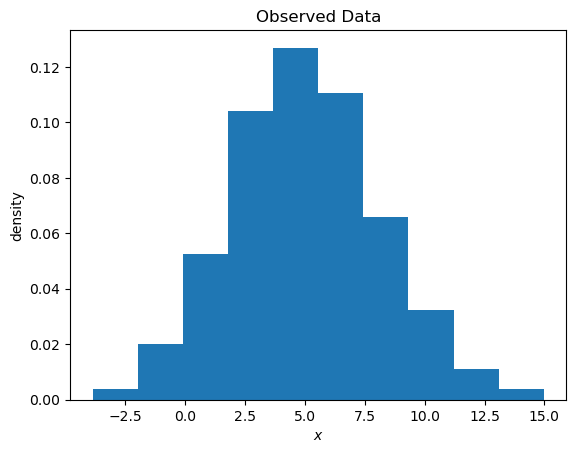

In [3]:
# True model parameters
mu = 5
sigma = 3
true_params = [mu, sigma]

# True model and generated "observed" data
model = GaussianModel(mu, sigma)
data = model.generate_data(1000)

# Parameter indices and names used for plotting
pidx1 = 0
pidx2 = 1
pname1 = "$\mu$"
pname2 = "$\sigma$"

plt.hist(data, density=True)
plt.title("Observed Data")
plt.xlabel('$x$');
plt.ylabel("density");

### Define priors


In [4]:
# Priors
prior_mu = UniformPrior(-20, 20)
prior_sigma = UniformPrior(0, 20)

prior_list = [prior_mu, prior_sigma]

### Compute summary statistics of the observed data and define a distance function


In [5]:
# Summary statistics of the observed data
data_mu = np.mean(data)
data_var = np.var(data)

# Distance function
def f_dist(x):
    mu_err = np.abs(np.mean(x) - data_mu) / data_mu
    var_err = np.abs(np.var(x) - data_var) / data_var
    return mu_err + var_err

### Define a simulation function

In [6]:
# Simulation function
def f_sim(particle, n=100):
    return GaussianModel(particle[0], particle[1]).generate_data(n)

## Run ABC-SMC

In [7]:
NTRIALS = 10
KERNEL_METHODS = ['gaussian', 'locm', 'mvn', 'uniform']
NPARTICLES = 1000
NITERS = 5

EPS_SCHED = [160, 120, 100, 80, 60, 40, 20, 10, 5, 4, 2, 1, 0.5, 0.25, 0.1]

acc_results = {km:np.zeros([NTRIALS, len(EPS_SCHED)]) for km in KERNEL_METHODS}
for km in KERNEL_METHODS:
    for trialidx in range(NTRIALS):
        particles, weights, results_dict = abcsmc(
            nparticles=NPARTICLES, 
            nparams=2, 
            prior_list=prior_list, 
            niters=NITERS,
            sim_func=f_sim,
            dist_func=f_dist, 
            eps_sched=EPS_SCHED,
            min_eps=0, 
            kernel_method=km,
            track_all_perturbations = False,
            verbosity=0,
            disable_pbars=True,
        )
        acc_results[km][trialidx,:] = results_dict['acceptance_rates']


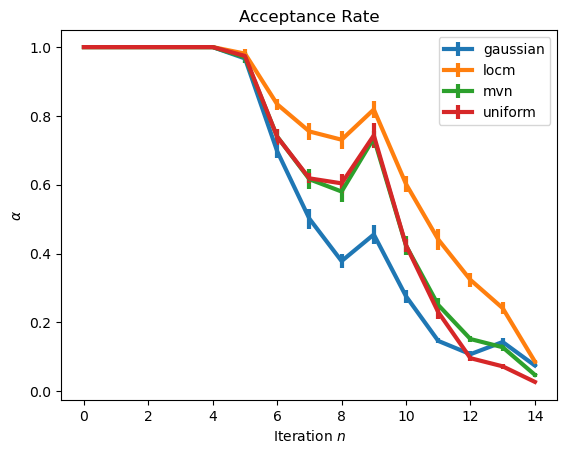

In [22]:
fig, ax = plt.subplots(1, 1)
ns = np.arange(len(EPS_SCHED), dtype=int)
for km in KERNEL_METHODS:
    acc_rates = acc_results[km]

    ax.errorbar(
        ns, np.mean(acc_rates, 0), 2*np.std(acc_rates, 0),
        label=km, 
        linewidth=3
    )
    # ax.errorbars(ns, acc_rates,)

ax.legend()
ax.set_xlabel("Iteration $n$")
ax.set_ylabel("$\\alpha$")
ax.set_title("Acceptance Rate")

plt.savefig(f"{imgdir}/comparison_acc_rates.png")